In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

from skimage import io, transform
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torch.optim as optim
from torch.autograd import Variable
from PIL import Image
import torchvision
from torchvision import models,transforms

from Dataloaders.HAM10000Dataset import HAM10000Dataset
from functions import normalization, Model_functions

import time

import random
from PIL import Image
import cv2
import gc

**Load and normalize the data**

In [6]:
data = pd.read_csv('data_enum.csv')
data = data.sample(frac=1)
img_h, img_w = 224, 224

In [5]:
# norm_means, norm_std = compute_img_mean_std(data['image_path'],img_h,img_w)

norm_means = [0.77148203, 0.55764165, 0.58345652]
norm_std = [0.12655577, 0.14245141, 0.15189891]

In [7]:
# define the transformation of the train images.
transform = transforms.Compose([transforms.Resize((img_h,img_w)),transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),transforms.RandomRotation(20),
                                      transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
                                        transforms.ToTensor(), transforms.Normalize(norm_means, norm_std)])
# define the transformation of the val and test images.
val_test_transform = transforms.Compose([transforms.Resize((img_h,img_w)), transforms.ToTensor(),
                                        transforms.Normalize(norm_means, norm_std)])

In [8]:
train_val_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

train_data, val_data = train_test_split(train_val_data, test_size=0.5, random_state=42)

train_dataset = HAM10000Dataset(train_data, transform=transform)
val_dataset = HAM10000Dataset(val_data, transform=transform)
test_dataset = HAM10000Dataset(test_data, transform=transform)

In [9]:
batch_size = 32
num_workers = 4

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

print('Data len Train:', len(train_dataset), 'Val:', len(val_dataset), 'Test:', len(test_dataset))

Data len Train: 12362 Val: 12362 Test: 6181


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


# **MobileNet_v3**

In [11]:
model_temp = 'mobilenet_v3'
feature_extract = False
num_classes = 7
model_res = Model_functions.initialise_model(model_temp, num_classes, feature_extract, use_pretrained=True)
model_res.to(device)

/root/miniconda3/envs/DNN/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/envs/DNN/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [12]:
input_size = (3, 224, 224)
print(summary(model_res, input_size, device=device.type))

Layer (type:depth-idx)                             Output Shape              Param #
├─Sequential: 1-1                                  [-1, 960, 7, 7]           --
|    └─Conv2dNormActivation: 2-1                   [-1, 16, 112, 112]        --
|    |    └─Conv2d: 3-1                            [-1, 16, 112, 112]        432
|    |    └─BatchNorm2d: 3-2                       [-1, 16, 112, 112]        32
|    |    └─Hardswish: 3-3                         [-1, 16, 112, 112]        --
|    └─InvertedResidual: 2-2                       [-1, 16, 112, 112]        --
|    |    └─Sequential: 3-4                        [-1, 16, 112, 112]        464
|    └─InvertedResidual: 2-3                       [-1, 24, 56, 56]          --
|    |    └─Sequential: 3-5                        [-1, 24, 56, 56]          3,440
|    └─InvertedResidual: 2-4                       [-1, 24, 56, 56]          --
|    |    └─Sequential: 3-6                        [-1, 24, 56, 56]          4,440
|    └─InvertedResidual: 2-

In [13]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model_res.parameters(), lr=1e-3)

In [14]:
start_time = time.time()

In [15]:
epochs = 30
patience = 5
model_filename = 'mobilenetv3_pret.pth'
resnet_model, total_loss_train, total_loss_val, total_acc_train, total_acc_val = Model_functions.train_and_validate_model(
                        model_res, train_loader, val_loader,test_loader, criterion,patience, optimizer, device, epochs, model_filename,verbose=True)

  3%|▎         | 1/30 [01:36<46:46, 96.77s/it]

Epoch 1
Training Loss: 0.5871692179324399 
Training Accuracy: 78.85455427924285%
Validation Loss: 0.3578526197477829 
Validation Accuracy: 87.08946772366932%
Validation Loss Decreased(inf--->0.357853) 
Saving The Model


  7%|▋         | 2/30 [03:13<45:04, 96.60s/it]

Epoch 2
Training Loss: 0.3301475148850171 
Training Accuracy: 88.15725610742598%
Validation Loss: 0.5103897253287238 
Validation Accuracy: 81.12764924769455%


 10%|█         | 3/30 [04:57<45:01, 100.06s/it]

Epoch 3
Training Loss: 0.2516008525682512 
Training Accuracy: 91.30399611713315%
Validation Loss: 0.2649088766310335 
Validation Accuracy: 91.04513832713153%
Validation Loss Decreased(0.357853--->0.264909) 
Saving The Model


 13%|█▎        | 4/30 [06:46<44:54, 103.64s/it]

Epoch 4
Training Loss: 0.20479509558586417 
Training Accuracy: 92.90567869276816%
Validation Loss: 0.4135141683602826 
Validation Accuracy: 86.1915547646012%


 17%|█▋        | 5/30 [08:28<42:57, 103.10s/it]

Epoch 5
Training Loss: 0.17964339074835142 
Training Accuracy: 93.96537777058728%
Validation Loss: 0.23454894867631815 
Validation Accuracy: 91.51431807150946%
Validation Loss Decreased(0.264909--->0.234549) 
Saving The Model


 20%|██        | 6/30 [10:14<41:38, 104.09s/it]

Epoch 6
Training Loss: 0.1546540378884097 
Training Accuracy: 94.62870085746643%
Validation Loss: 0.22780974722979952 
Validation Accuracy: 92.92994661058081%
Validation Loss Decreased(0.234549--->0.227810) 
Saving The Model


 23%|██▎       | 7/30 [11:57<39:47, 103.80s/it]

Epoch 7
Training Loss: 0.14660953281529113 
Training Accuracy: 95.00080893059375%
Validation Loss: 0.15099278801585275 
Validation Accuracy: 94.9118265652807%
Validation Loss Decreased(0.227810--->0.150993) 
Saving The Model


 27%|██▋       | 8/30 [13:22<35:48, 97.68s/it] 

Epoch 8
Training Loss: 0.13164705943884158 
Training Accuracy: 95.97152564309982%
Validation Loss: 1.211619206331189 
Validation Accuracy: 67.88545542792428%


 30%|███       | 9/30 [14:48<32:53, 93.98s/it]

Epoch 9
Training Loss: 0.12820647676530697 
Training Accuracy: 95.80165021841125%
Validation Loss: 0.12302574527134652 
Validation Accuracy: 95.80973952434881%
Validation Loss Decreased(0.150993--->0.123026) 
Saving The Model


 33%|███▎      | 10/30 [16:20<31:05, 93.27s/it]

Epoch 10
Training Loss: 0.10195405080551113 
Training Accuracy: 96.61867011810386%
Validation Loss: 0.21973955540289714 
Validation Accuracy: 93.17262578870734%


 37%|███▋      | 11/30 [17:56<29:53, 94.39s/it]

Epoch 11
Training Loss: 0.11559950395785658 
Training Accuracy: 96.35172302216469%
Validation Loss: 0.1824306579744708 
Validation Accuracy: 93.44766219058405%


 40%|████      | 12/30 [19:35<28:40, 95.59s/it]

Epoch 12
Training Loss: 0.09173698190513045 
Training Accuracy: 96.90179582591814%
Validation Loss: 0.16655818302694525 
Validation Accuracy: 94.73386183465459%


 43%|████▎     | 13/30 [21:05<26:38, 94.00s/it]

Epoch 13
Training Loss: 0.09094060967102989 
Training Accuracy: 97.00695680310629%
Validation Loss: 0.11437303158460613 
Validation Accuracy: 96.12522245591329%
Validation Loss Decreased(0.123026--->0.114373) 
Saving The Model


 47%|████▋     | 14/30 [22:30<24:22, 91.38s/it]

Epoch 14
Training Loss: 0.10268824496119974 
Training Accuracy: 96.83708137841774%
Validation Loss: 0.20953539474349883 
Validation Accuracy: 93.3101439896457%


 50%|█████     | 15/30 [23:55<22:22, 89.47s/it]

Epoch 15
Training Loss: 0.1002579425959138 
Training Accuracy: 96.91797443779323%
Validation Loss: 0.07214710901603247 
Validation Accuracy: 97.69454780779809%
Validation Loss Decreased(0.114373--->0.072147) 
Saving The Model


 53%|█████▎    | 16/30 [25:35<21:34, 92.45s/it]

Epoch 16
Training Loss: 0.06285239526104346 
Training Accuracy: 97.9048697621744%
Validation Loss: 0.07174519817203462 
Validation Accuracy: 97.93722698592461%
Validation Loss Decreased(0.072147--->0.071745) 
Saving The Model


 57%|█████▋    | 17/30 [27:25<21:10, 97.70s/it]

Epoch 17
Training Loss: 0.07035846171511977 
Training Accuracy: 97.83206600873645%
Validation Loss: 0.25295488909007235 
Validation Accuracy: 92.40414172464003%


 60%|██████    | 18/30 [29:15<20:16, 101.38s/it]

Epoch 18
Training Loss: 0.08501381904314854 
Training Accuracy: 97.20918945154506%
Validation Loss: 0.07994360317238375 
Validation Accuracy: 97.8725125384242%


 63%|██████▎   | 19/30 [30:46<18:03, 98.49s/it] 

Epoch 19
Training Loss: 0.07498161198414299 
Training Accuracy: 97.56511891279729%
Validation Loss: 0.08656805177181309 
Validation Accuracy: 97.50849377123443%


 67%|██████▋   | 20/30 [32:17<16:01, 96.19s/it]

Epoch 20
Training Loss: 0.06723829867892528 
Training Accuracy: 97.88869115029931%
Validation Loss: 0.1604952897602534 
Validation Accuracy: 95.68839993528555%


100%|██████████| 30/30 [33:42<00:00, 67.40s/it]

Epoch 21
Training Loss: 0.10312834315366552 
Training Accuracy: 96.99077819123119%
Validation Loss: 0.08802610526557919 
Validation Accuracy: 97.64601197217279%


In [16]:
end_time = time.time()
total_time = end_time - start_time
print(f"Total training and validation time for the Resnet Pretrainned Model: {total_time/60:.2f} minutes")
elapsed_time = end_time - start_time

Total training and validation time for the Resnet Pretrainned Model: 34.07 minutes


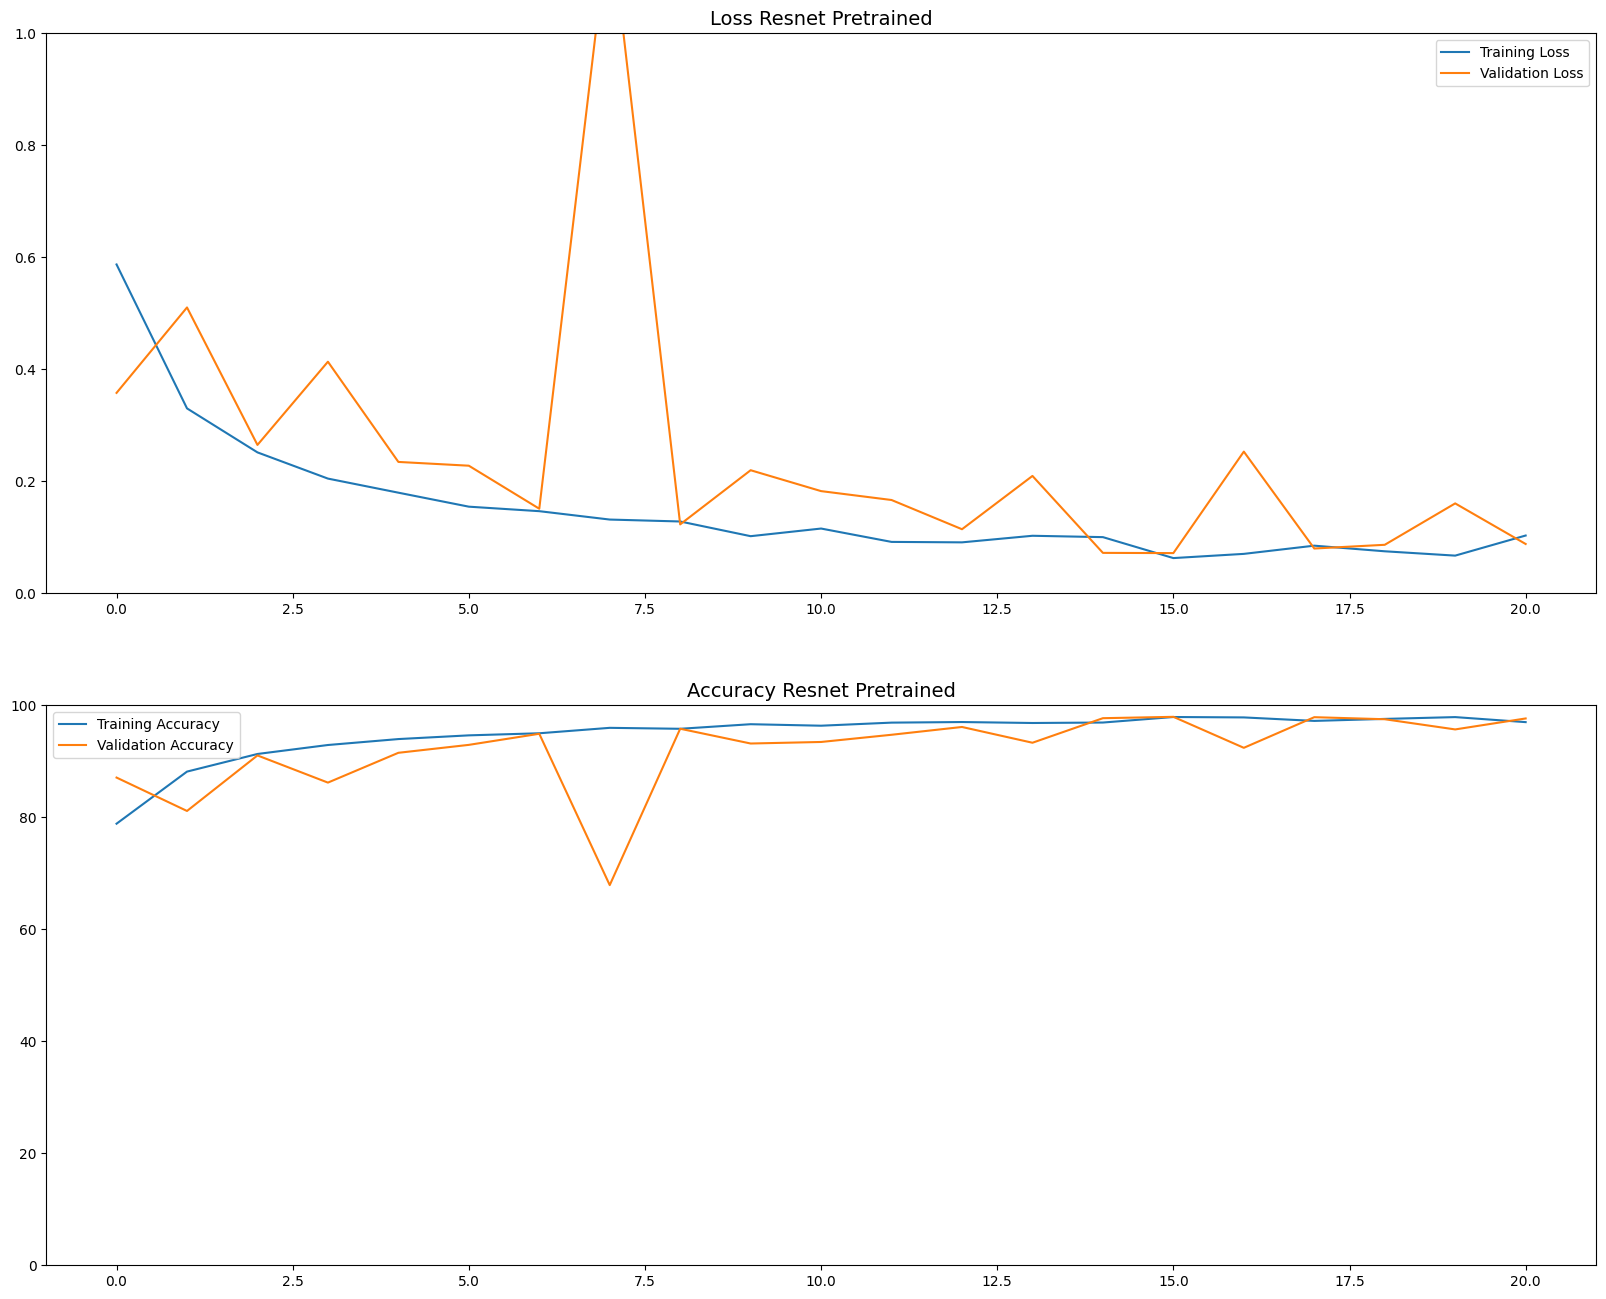

In [17]:
fig = plt.figure(num=2, figsize=(20, 16))  
fig1 = fig.add_subplot(2, 1, 1)
fig2 = fig.add_subplot(2, 1, 2)

fig1.plot(total_loss_train, label='Training Loss')
fig1.plot(total_loss_val, label='Validation Loss')
fig1.set_title('Loss Resnet Pretrained', fontsize=14)  
fig1.set_ylim([0, 1])
fig1.legend()
fig2.plot(total_acc_train, label='Training Accuracy')
fig2.plot(total_acc_val, label='Validation Accuracy')
fig2.set_ylim([0, 100])
fig2.set_title('Accuracy Resnet Pretrained', fontsize=14)  
fig2.legend()
plt.show()

In [18]:
best_model_state = torch.load('mobilenetv3_pret.pth', map_location='cpu')
model_res.load_state_dict(best_model_state)
model_res.to('cpu')  
device = torch.device('cpu')
test_accuracy = Model_functions.test_model(model_res, test_loader, device)

print('-------------------------------------------------------')
print(f'Best model\'s accuracy: {test_accuracy}')
print('-------------------------------------------------------')


-------------------------------------------------------
Best model's accuracy: 98.13945963436338
-------------------------------------------------------


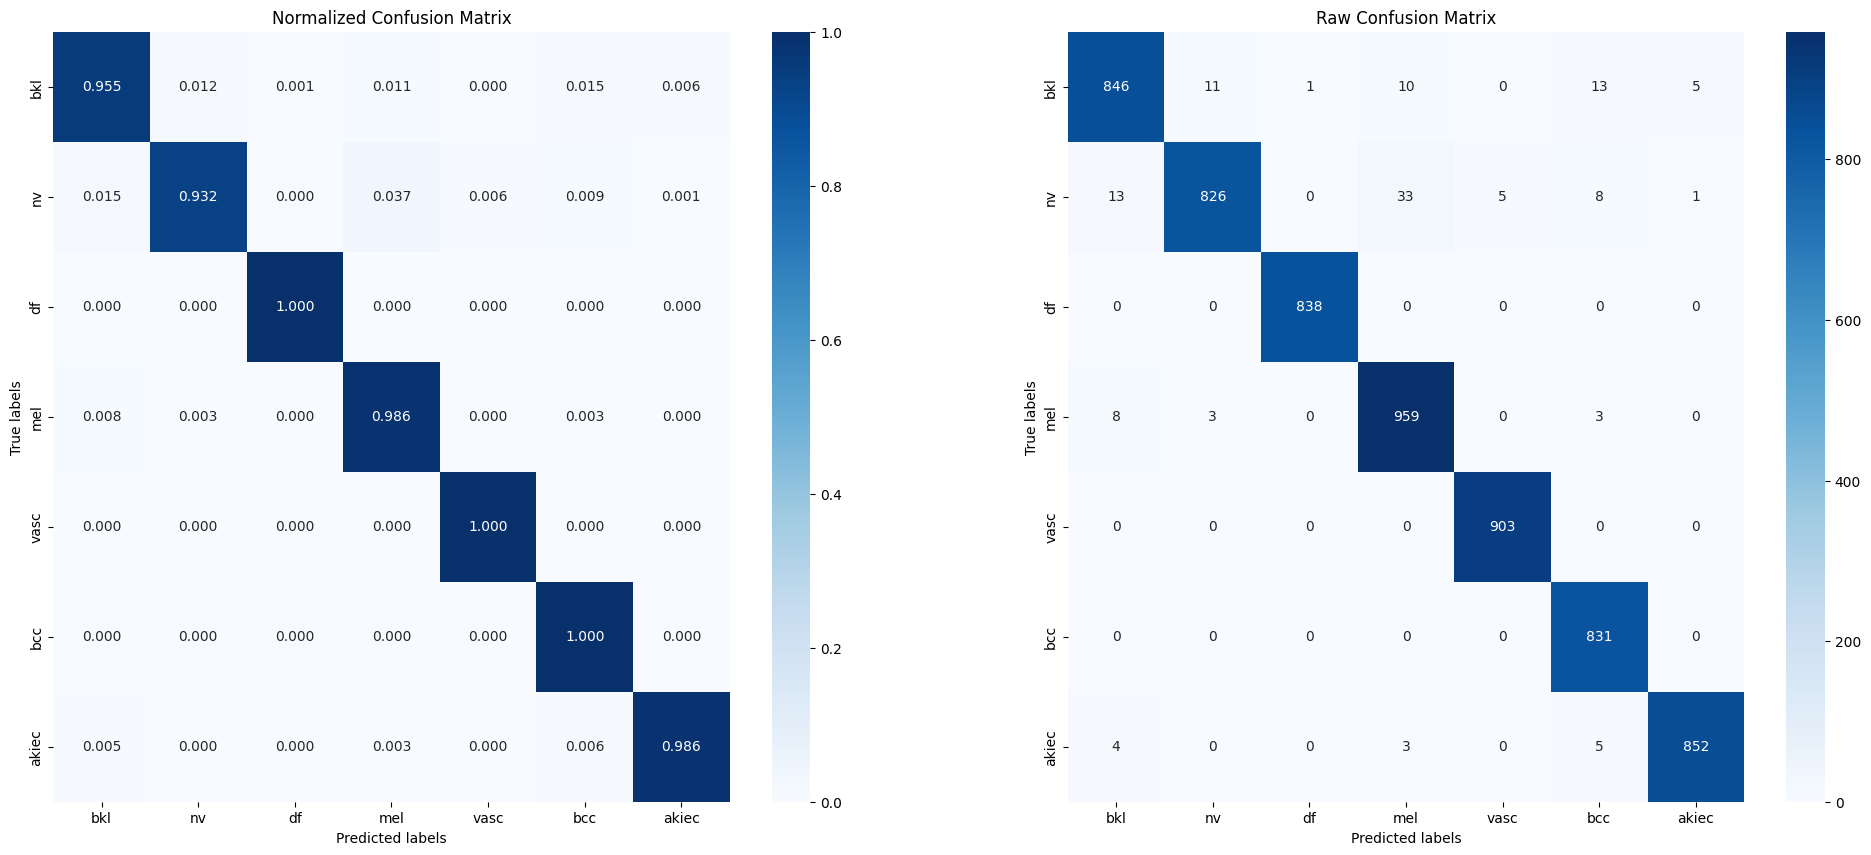

-------------------------------------------------------
Classification Report:

              precision    recall  f1-score   support

         bkl       0.97      0.95      0.96       886
          nv       0.98      0.93      0.96       886
          df       1.00      1.00      1.00       838
         mel       0.95      0.99      0.97       973
        vasc       0.99      1.00      1.00       903
         bcc       0.97      1.00      0.98       831
       akiec       0.99      0.99      0.99       864

    accuracy                           0.98      6181
   macro avg       0.98      0.98      0.98      6181
weighted avg       0.98      0.98      0.98      6181

-------------------------------------------------------


In [19]:
Model_functions.conf_report(model_res, test_loader, 'resnet_conf_mat')

**Empty the CUDA memory**

In [20]:
torch.cuda.empty_cache() 
gc.collect()

15220

In [31]:
# torch.cuda.memory_summary(device=None, abbreviated=False)

# **Effecient Net**

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [27]:
model_temp = 'effiecentnet'
num_classes = 7
feature_extract = False
model_des = Model_functions.initialise_model(model_temp, num_classes, feature_extract, use_pretrained=True)
model_des.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [28]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model_des.parameters(), lr=1e-3)

In [29]:
input_size = (3, 224, 224)
print(summary(model_des, input_size, device=device.type))

Layer (type:depth-idx)                        Output Shape              Param #
├─Sequential: 1-1                             [-1, 1280, 7, 7]          --
|    └─Conv2dNormActivation: 2-1              [-1, 32, 112, 112]        --
|    |    └─Conv2d: 3-1                       [-1, 32, 112, 112]        864
|    |    └─BatchNorm2d: 3-2                  [-1, 32, 112, 112]        64
|    |    └─SiLU: 3-3                         [-1, 32, 112, 112]        --
|    └─Sequential: 2-2                        [-1, 16, 112, 112]        --
|    |    └─MBConv: 3-4                       [-1, 16, 112, 112]        1,448
|    |    └─MBConv: 3-5                       [-1, 16, 112, 112]        612
|    └─Sequential: 2-3                        [-1, 24, 56, 56]          --
|    |    └─MBConv: 3-6                       [-1, 24, 56, 56]          6,004
|    |    └─MBConv: 3-7                       [-1, 24, 56, 56]          10,710
|    |    └─MBConv: 3-8                       [-1, 24, 56, 56]          10,710
|   

In [30]:
start_time = time.time()

In [32]:
epochs = 10
patience = 5
model_filename = 'effiecentnet.pth'
densenet_model, total_loss_train, total_loss_val, total_acc_train, total_acc_val = Model_functions.train_and_validate_model(
                        model_des, train_loader, val_loader,test_loader, criterion,patience, optimizer, device, epochs, model_filename,verbose=True)

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [01:25<12:52, 85.83s/it]

Epoch 1
Training Loss: 0.4731748256572457 
Training Accuracy: 83.36838699239605%
Validation Loss: 0.25000130954061367 
Validation Accuracy: 91.40106778838376%
Validation Loss Decreased(inf--->0.250001) 
Saving The Model


 20%|██        | 2/10 [02:57<11:52, 89.12s/it]

Epoch 2
Training Loss: 0.2622369109948938 
Training Accuracy: 91.22310305775764%
Validation Loss: 0.13581600724370518 
Validation Accuracy: 95.47807798090923%
Validation Loss Decreased(0.250001--->0.135816) 
Saving The Model


 30%|███       | 3/10 [04:35<10:54, 93.45s/it]

Epoch 3
Training Loss: 0.18778241451261735 
Training Accuracy: 93.69843067464811%
Validation Loss: 0.14771215335853416 
Validation Accuracy: 95.16259504934477%


 40%|████      | 4/10 [06:20<09:46, 97.69s/it]

Epoch 4
Training Loss: 0.15665974884922074 
Training Accuracy: 94.58016502184113%
Validation Loss: 0.10856421762603294 
Validation Accuracy: 96.55395567060346%
Validation Loss Decreased(0.135816--->0.108564) 
Saving The Model


 50%|█████     | 5/10 [07:47<07:49, 93.90s/it]

Epoch 5
Training Loss: 0.12212107002191265 
Training Accuracy: 95.89872188966187%
Validation Loss: 0.09833169606085915 
Validation Accuracy: 96.74809901310468%
Validation Loss Decreased(0.108564--->0.098332) 
Saving The Model


 60%|██████    | 6/10 [09:17<06:10, 92.74s/it]

Epoch 6
Training Loss: 0.11876498106433901 
Training Accuracy: 95.99579356091247%
Validation Loss: 0.10097432171670812 
Validation Accuracy: 96.90988513185569%


 70%|███████   | 7/10 [10:47<04:35, 91.79s/it]

Epoch 7
Training Loss: 0.09903577835905518 
Training Accuracy: 96.65102734185407%
Validation Loss: 0.0882326781467561 
Validation Accuracy: 97.40333279404626%
Validation Loss Decreased(0.098332--->0.088233) 
Saving The Model


 80%|████████  | 8/10 [12:24<03:06, 93.41s/it]

Epoch 8
Training Loss: 0.09756838816737887 
Training Accuracy: 96.82899207248018%
Validation Loss: 0.09158389043310797 
Validation Accuracy: 97.2172787574826%


 90%|█████████ | 9/10 [13:59<01:33, 93.84s/it]

Epoch 9
Training Loss: 0.0835164790739635 
Training Accuracy: 97.29008251092057%
Validation Loss: 0.07750899534466742 
Validation Accuracy: 97.41142209998382%
Validation Loss Decreased(0.088233--->0.077509) 
Saving The Model


100%|██████████| 10/10 [15:36<00:00, 93.63s/it]

Epoch 10
Training Loss: 0.08925557954842105 
Training Accuracy: 96.87752790810548%
Validation Loss: 0.07903283510923576 
Validation Accuracy: 97.7269050315483%


In [33]:
end_time = time.time()
total_time = end_time - start_time
print(f"Total training and validation time for Pretrainned Densenet model: {total_time/60:.2f} minutes")

Total training and validation time for Pretrainned Densenet model: 16.26 minutes


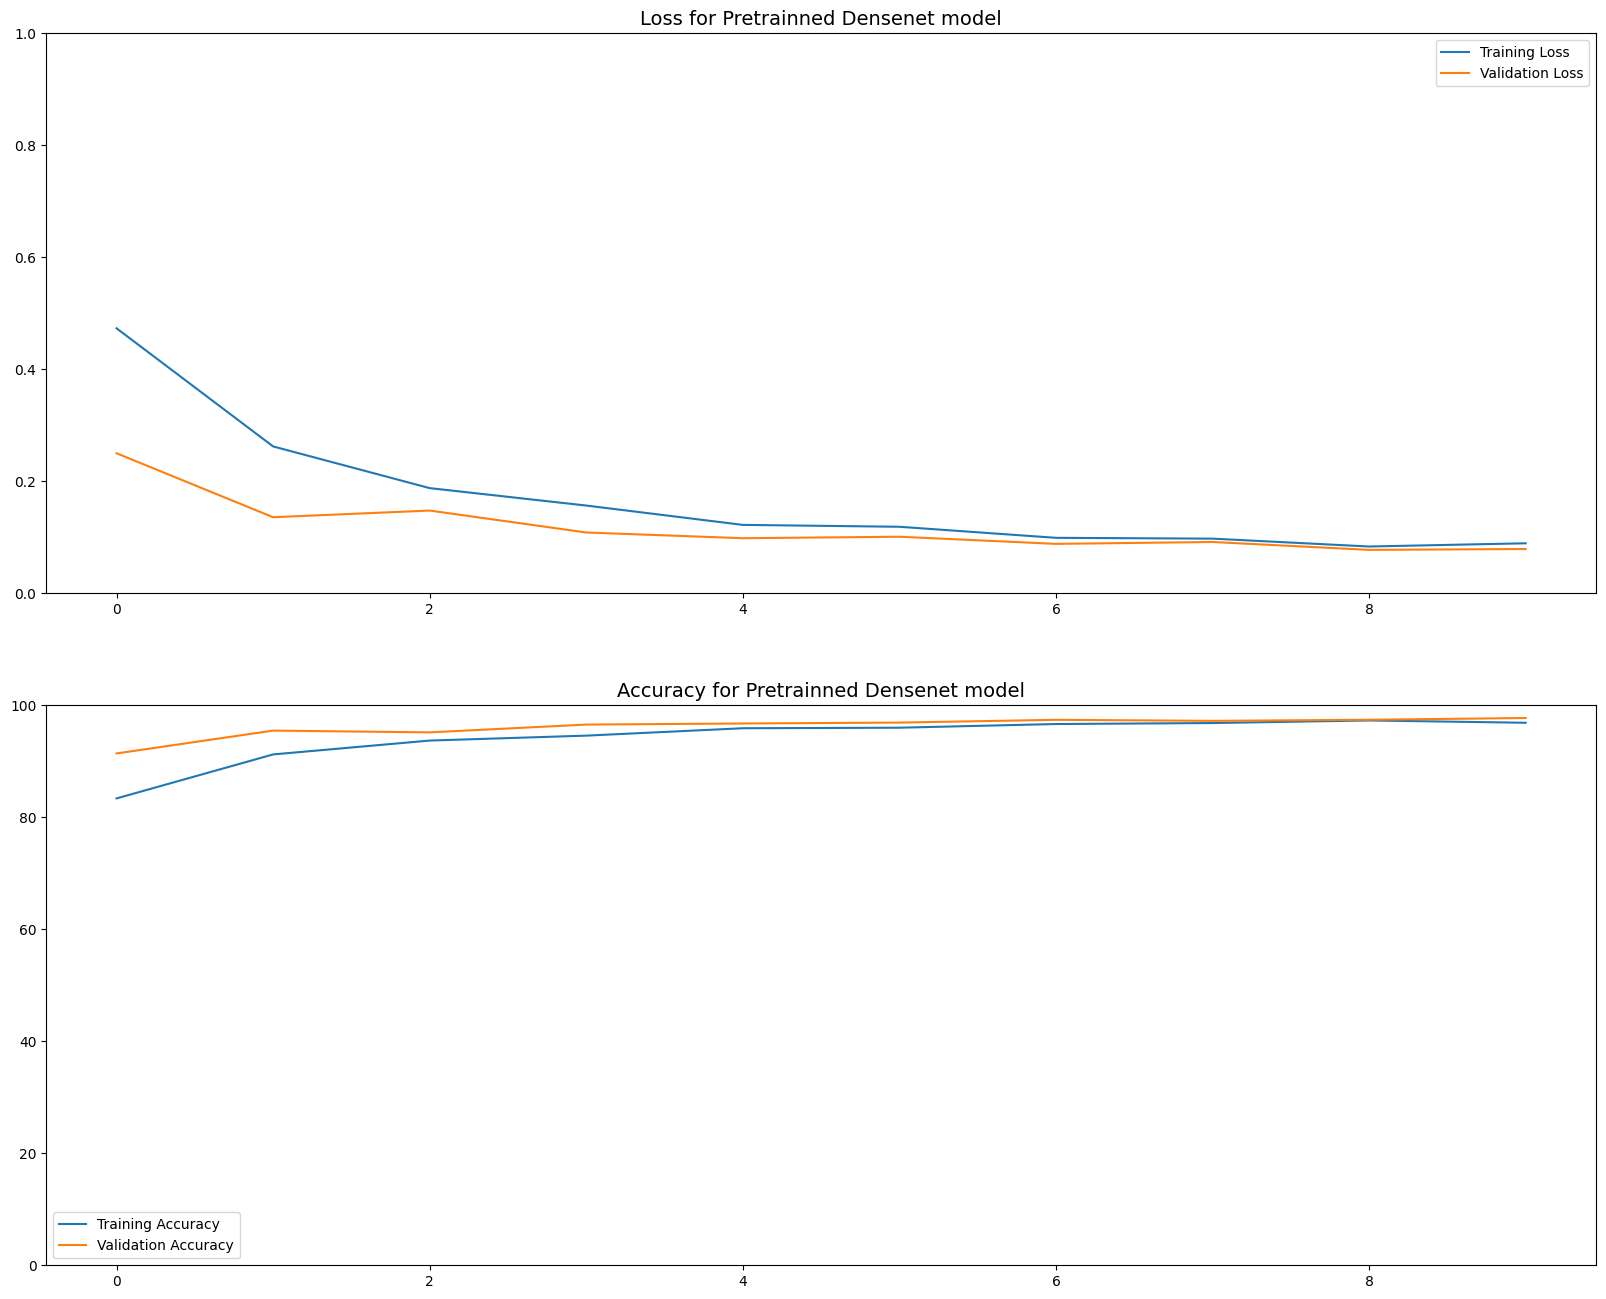

In [35]:
fig = plt.figure(num=2, figsize=(20, 16))  
fig1 = fig.add_subplot(2, 1, 1)
fig2 = fig.add_subplot(2, 1, 2)

fig1.plot(total_loss_train, label='Training Loss')
fig1.plot(total_loss_val, label='Validation Loss')
fig1.set_ylim([0, 1])
fig1.set_title('Loss for Pretrainned Densenet model', fontsize=14)  
fig1.legend()
fig2.plot(total_acc_train, label='Training Accuracy')
fig2.plot(total_acc_val, label='Validation Accuracy')
fig2.set_ylim([0, 100])
fig2.set_title('Accuracy for Pretrainned Densenet model', fontsize=14)  
fig2.legend()
plt.show()

In [34]:
best_model_state = torch.load('effiecentnet.pth',map_location='cpu')
device = torch.device('cpu')
model_des.load_state_dict(best_model_state)
model_des.to(device)
test_accuracy = Model_functions.test_model(model_des, test_loader, device)
print('-------------------------------------------------------')
print(f'Best models accuracy {test_accuracy}')
print('-------------------------------------------------------')

-------------------------------------------------------
Best models accuracy 97.37906487623361
-------------------------------------------------------


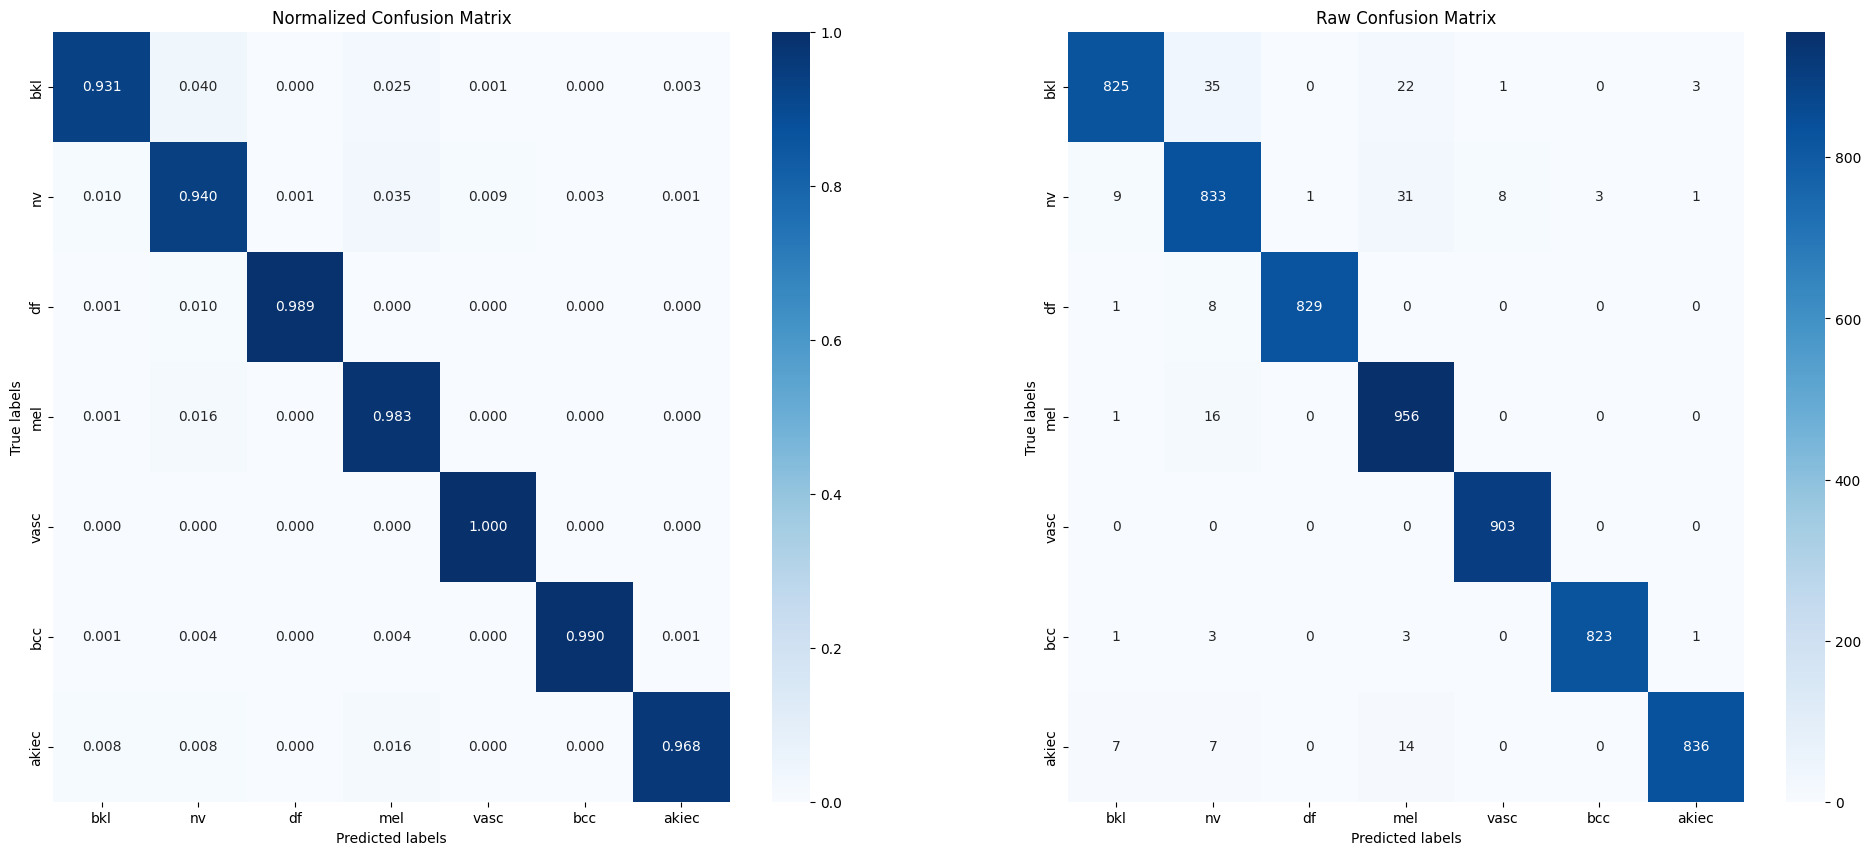

-------------------------------------------------------
Classification Report:

              precision    recall  f1-score   support

         bkl       0.98      0.93      0.95       886
          nv       0.92      0.94      0.93       886
          df       1.00      0.99      0.99       838
         mel       0.93      0.98      0.96       973
        vasc       0.99      1.00      1.00       903
         bcc       1.00      0.99      0.99       831
       akiec       0.99      0.97      0.98       864

    accuracy                           0.97      6181
   macro avg       0.97      0.97      0.97      6181
weighted avg       0.97      0.97      0.97      6181

-------------------------------------------------------


In [36]:
Model_functions.conf_report(model_des, test_loader, 'densenet_conf_mat')